In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, ReLU, BatchNormalization, Reshape, UpSampling2D, Conv2D, Activation
from keras.utils import np_utils

# 생성자 Generator

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size = 3, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 3, padding = 'same', activation = 'tanh'))



*   Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2))
    > 128, 100은 임의의 수, 7x7 이미지를 2번 **UpSampling2D**하면 28x28 이미지가 됨

*   Reshape((7,7,128))
    > 뒤의 **Conv2D**에 들어갈 형태로 바꾸어 주는 코드

*   Conv2D(64, kernel_size = 5, paddding = 'same')
    > 커널 크기를 3으로, **padding = 'same'** 을 통해 모자라는 부분은 자동으로 0이 채워짐

*   LeakyReLU(0.2)
    > GAN에서는 기존의 ReLU방식은 학습이 불안정, 변형한 LeakyReLU를 사용
    
    > 0보다 작을 경우 0.2를 곱하라는 의미

# 판별자 Discriminator

In [ ]:
from keras.layers import MaxPooling2D, Dropout, Flatten, Input

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', input_shape=(28, 28, 1)))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())

discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False # 판별자가 학습하지 않도록 학습기능 off

# 생성자-판별자 연결하기
  > 생성자의 결과값을 판별자에 입력 후 판별

In [ ]:
from keras.models import Model

# 생성자와 판별자를 연결시키는 GAN모델 생성
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')

## 판별자에 **실제&가상 이미지**를 입력

In [ ]:
from keras.datasets import mnist
import os
from tqdm import tqdm

def gan_train(epoch, batch_size, saving_interval):

  #MNIST 데이터에서 이미지만 사용
  (X_train, _), (_,_) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28,28, 1).astype('float32')
  
  X_train = (X_train - 127.5) / 127.5    # 0 ~ 255 사이의 값을 -1 ~ 1 사이의 값으로 변환

  for i in tqdm(range(epoch)):
    #실제 이미지
    true = np.ones((batch_size, 1))
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    #가상 이미지
    fake = np.zeros((batch_size, 1))
    noise = np.random.normal(0,1, (batch_size, 100))
    gen_images = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_images, fake)

    #오차값
    d_loss = np.add(d_loss_fake, d_loss_real) / 2

    g_loss = gan.train_on_batch(noise, true)

    if i % saving_interval == 0:  
      print('epoch : %d '%i, 'd_loss : %.4f'%d_loss, 'g_loss : %.4f'%g_loss)



    #중간 과정을 이미지로 저장하는 부분 (saving_interval마다 저장)
    Dir = './gan_images/'
    if not os.path.exists(Dir):
      os.mkdir(Dir)

    if i % saving_interval == 0:
      noise = np.random.normal(0,1,(25,100))
      gen_imgs = generator.predict(noise)

      #img를 0 ~ 1로 rescale
      gen_imgs = gen_imgs / 2 + 0.5

      fig,axs = plt.subplots(5,5)
      cnt = 0
      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
          axs[j, k].axis('off')
          cnt += 1
          fig.savefig("gan_images/gan_mnist_%d.png"% i)

* 실제 이미지 입력
  1. 1로 이루어진 배열을 batch_size 길이로 생성
  2. X_train에서 랜덤으로 하나의 이미지를 가져오는걸 batch_size만큼 반복
  3. 판별자 모델에 train_on_batch 함수를 통해 입력


* 가상 이미지 입력
  1. 0로 이루어진 배열을 batch_size 길이로 생성
  2. 0과 1사이의 소수를 랜덤 선택
  3. 판별자 모델에 train_on_batch 함수를 통해 입력


* train_on_batch : x,y를 받아서 학습을 한번 실시 후 모델 업데이트


  0%|          | 0/4001 [00:00<?, ?it/s]

epoch : 0  d_loss : 0.7458 g_loss : 0.3428


  5%|▍         | 200/4001 [01:52<33:14,  1.91it/s]

epoch : 200  d_loss : 0.4011 g_loss : 1.3318


 10%|▉         | 400/4001 [03:44<31:47,  1.89it/s]

epoch : 400  d_loss : 0.2083 g_loss : 3.2947


 15%|█▍        | 600/4001 [05:35<29:54,  1.89it/s]

epoch : 600  d_loss : 0.3042 g_loss : 1.7434


 20%|█▉        | 800/4001 [07:26<28:19,  1.88it/s]

epoch : 800  d_loss : 0.4043 g_loss : 1.9134


 25%|██▍       | 1000/4001 [09:17<25:52,  1.93it/s]

epoch : 1000  d_loss : 0.4330 g_loss : 2.4401


 30%|██▉       | 1200/4001 [11:08<24:44,  1.89it/s]

epoch : 1200  d_loss : 0.4223 g_loss : 2.2590


 35%|███▍      | 1400/4001 [13:01<22:56,  1.89it/s]

epoch : 1400  d_loss : 0.3486 g_loss : 2.2232


 40%|███▉      | 1600/4001 [14:53<21:39,  1.85it/s]

epoch : 1600  d_loss : 0.3858 g_loss : 1.5620


 45%|████▍     | 1800/4001 [16:46<19:55,  1.84it/s]

epoch : 1800  d_loss : 0.4547 g_loss : 1.7308


 50%|████▉     | 2000/4001 [18:38<17:34,  1.90it/s]

epoch : 2000  d_loss : 0.3619 g_loss : 1.9746


 55%|█████▍    | 2200/4001 [20:29<15:41,  1.91it/s]

epoch : 2200  d_loss : 0.4632 g_loss : 1.7200


 60%|█████▉    | 2400/4001 [22:20<13:55,  1.92it/s]

epoch : 2400  d_loss : 0.5113 g_loss : 1.2855


 65%|██████▍   | 2600/4001 [24:09<12:07,  1.92it/s]

epoch : 2600  d_loss : 0.4444 g_loss : 1.4823


 70%|██████▉   | 2800/4001 [25:58<10:35,  1.89it/s]

epoch : 2800  d_loss : 0.5839 g_loss : 1.2850


 75%|███████▍  | 3000/4001 [27:47<08:31,  1.96it/s]

epoch : 3000  d_loss : 0.4871 g_loss : 1.5105


 80%|███████▉  | 3200/4001 [29:35<06:44,  1.98it/s]

epoch : 3200  d_loss : 0.4432 g_loss : 1.5163


 85%|████████▍ | 3400/4001 [31:24<05:13,  1.92it/s]

epoch : 3400  d_loss : 0.3498 g_loss : 2.0436


 90%|████████▉ | 3600/4001 [33:12<03:22,  1.98it/s]

epoch : 3600  d_loss : 0.5713 g_loss : 1.5843


 95%|█████████▍| 3800/4001 [34:58<01:41,  1.98it/s]

epoch : 3800  d_loss : 0.5991 g_loss : 1.6138


100%|█████████▉| 4000/4001 [36:45<00:00,  1.97it/s]

epoch : 4000  d_loss : 0.3539 g_loss : 1.8105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 4001/4001 [36:51<00:00,  1.81it/s]


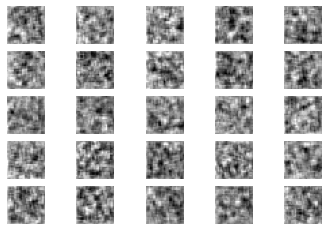

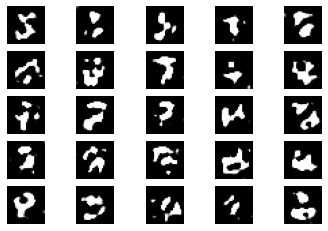

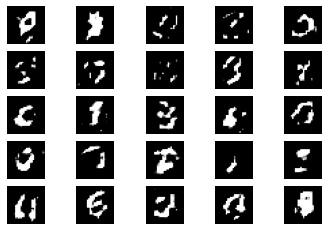

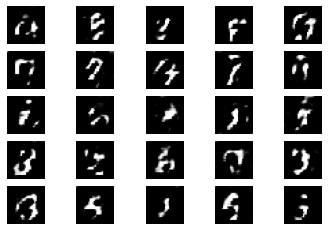

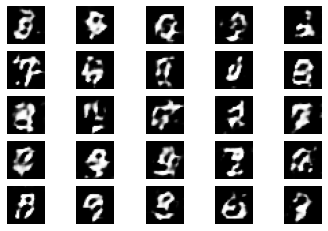

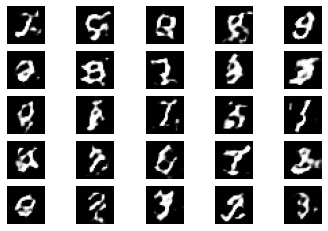

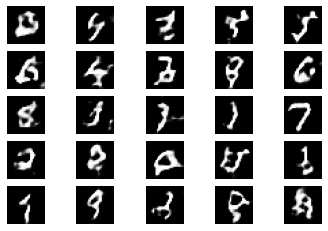

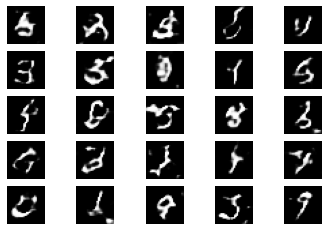

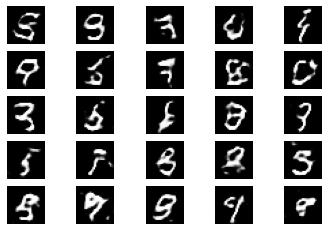

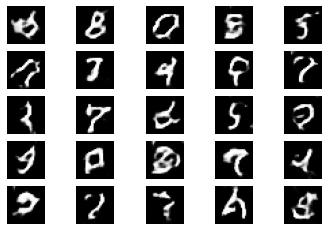

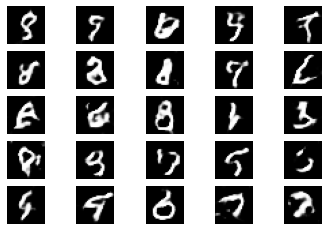

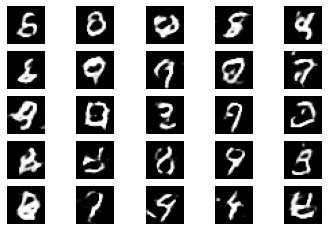

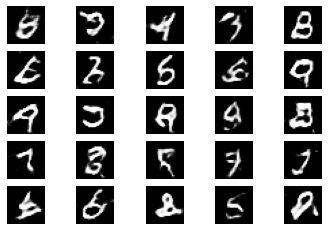

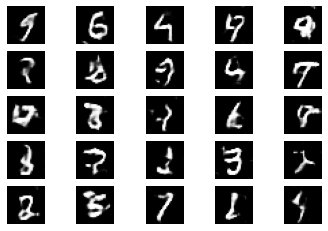

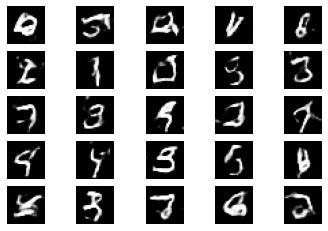

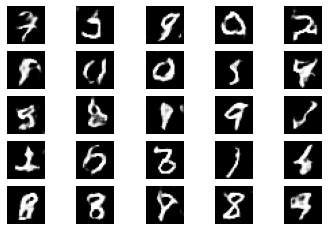

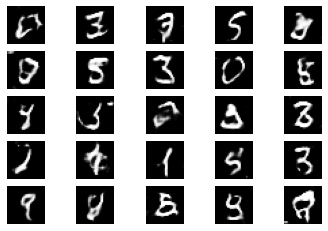

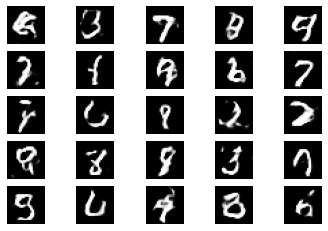

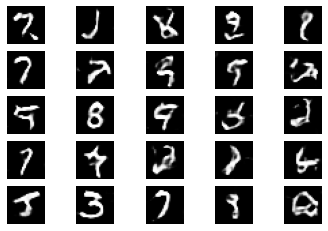

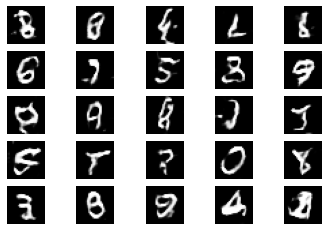

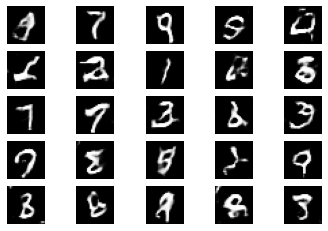

In [ ]:
gan_train(4001, 32, 200)